# Projekt ML - Przewidywanie Intencji Zakupowych Online Shoppers

## Cel Projektu
Klasyfikacja binarna przewidująca, czy użytkownik dokona zakupu (kolumna `Revenue`) na podstawie danych o zachowaniu na stronie e-commerce.

## Uwaga
Klasy OOP są zdefiniowane w tym notebooku. Alternatywnie można zaimportować klasy z pliku `ml_classes.py`:
```python
from ml_classes import DataLoader, DataPreprocessor, DataAnalyzer, FeatureEngineer, ModelTrainer, HyperparameterTuner
```
Plik `ml_classes.py` jest używany przez testy jednostkowe.


## 1. Import bibliotek


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import warnings
warnings.filterwarnings('ignore')

# Konfiguracja wizualizacji
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline


## 2. Definicja klas OOP


In [2]:
class DataLoader:
    """Klasa odpowiedzialna za wczytanie danych z pliku CSV"""
    
    def __init__(self):
        self.data = None
        self.path = None
    
    def load_data(self, path: str) -> pd.DataFrame:
        """
        Wczytuje dane z pliku CSV
        
        Parameters:
        -----------
        path : str
            Ścieżka do pliku CSV
            
        Returns:
        --------
        pd.DataFrame
            Wczytane dane
        """
        try:
            self.data = pd.read_csv(path)
            self.path = path
            print(f"Dane wczytane pomyślnie z: {path}")
            print(f"Kształt danych: {self.data.shape}")
            return self.data
        except Exception as e:
            print(f"Błąd podczas wczytania danych: {e}")
            return None
    
    def get_info(self) -> dict:
        """
        Zwraca podstawowe informacje o zbiorze danych
        
        Returns:
        --------
        dict
            Słownik z informacjami o danych
        """
        if self.data is None:
            return {"error": "Dane nie zostały wczytane"}
        
        info = {
            "shape": self.data.shape,
            "columns": list(self.data.columns),
            "dtypes": self.data.dtypes.to_dict(),
            "missing_values": self.data.isnull().sum().to_dict(),
            "memory_usage": self.data.memory_usage(deep=True).sum()
        }
        return info


In [3]:
class DataPreprocessor:
    """Klasa odpowiedzialna za preprocessing danych"""
    
    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.is_fitted = False 
    
    def handle_missing_values(self, df: pd.DataFrame, strategy: str = 'drop') -> pd.DataFrame:
        """
        Obsługuje brakujące wartości
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do przetworzenia
        strategy : str
            Strategia obsługi ('drop', 'mean', 'median', 'mode')
            
        Returns:
        --------
        pd.DataFrame
            DataFrame po obsłudze brakujących wartości
        """
        df_processed = df.copy()
        
        if strategy == 'drop':
            df_processed = df_processed.dropna()
        elif strategy == 'mean':
            numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
            df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].mean())
        elif strategy == 'median':
            numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
            df_processed[numeric_cols] = df_processed[numeric_cols].fillna(df_processed[numeric_cols].median())
        elif strategy == 'mode':
            for col in df_processed.columns:
                df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0] if not df_processed[col].mode().empty else 0)
        
        return df_processed
    
    def encode_categorical(self, df: pd.DataFrame, columns: list = None, method: str = 'label') -> pd.DataFrame:
        """
        Koduje zmienne kategoryczne
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do przetworzenia
        columns : list
            Lista kolumn do zakodowania (None = automatyczne wykrycie)
        method : str
            Metoda kodowania ('label' lub 'onehot')
            
        Returns:
        --------
        pd.DataFrame
            DataFrame z zakodowanymi zmiennymi
        """
        df_encoded = df.copy()
        
        if columns is None:
            # Automatyczne wykrycie kolumn kategorycznych
            categorical_cols = df_encoded.select_dtypes(include=['object', 'bool']).columns.tolist()
        else:
            categorical_cols = columns
        
        if method == 'label':
            for col in categorical_cols:
                if col in df_encoded.columns:
                    le = LabelEncoder()
                    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
                    self.label_encoders[col] = le
        elif method == 'onehot':
            df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, prefix=categorical_cols)
        
        return df_encoded
    
    def normalize_features(self, df: pd.DataFrame, columns: list = None, fit: bool = True) -> pd.DataFrame:
        """
        Normalizuje zmienne numeryczne
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do przetworzenia
        columns : list
            Lista kolumn do normalizacji (None = wszystkie numeryczne)
        fit : bool
            Czy dopasować scaler (True dla train, False dla test)
            
        Returns:
        --------
        pd.DataFrame
            DataFrame z znormalizowanymi zmiennymi
        """
        df_normalized = df.copy()
        
        if columns is None:
            numeric_cols = df_normalized.select_dtypes(include=[np.number]).columns.tolist()
        else:
            numeric_cols = columns
        
        if fit:
            df_normalized[numeric_cols] = self.scaler.fit_transform(df_normalized[numeric_cols])
            self.is_fitted = True
        else:
            if not self.is_fitted:
                raise ValueError("Scaler nie został dopasowany. Użyj fit=True dla danych treningowych.")
            df_normalized[numeric_cols] = self.scaler.transform(df_normalized[numeric_cols])
        
        return df_normalized
    
    def preprocess_pipeline(self, df: pd.DataFrame, target_col: str = None, 
                           handle_missing: str = 'drop', encode_method: str = 'label',
                           normalize: bool = True, fit: bool = True) -> tuple:
        """
        Pełny pipeline preprocessingu
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do przetworzenia
        target_col : str
            Nazwa kolumny docelowej (jeśli None, nie separuje)
        handle_missing : str
            Strategia obsługi brakujących wartości
        encode_method : str
            Metoda kodowania kategorycznych
        normalize : bool
            Czy normalizować zmienne
        fit : bool
            Czy dopasować transformatory (True dla train)
            
        Returns:
        --------
        tuple
            (X, y) lub (df_processed, None) jeśli target_col=None
        """
        df_processed = df.copy()
        
        # Obsługa brakujących wartości
        df_processed = self.handle_missing_values(df_processed, strategy=handle_missing)
        
        # Separacja targetu jeśli podany
        if target_col and target_col in df_processed.columns:
            y = df_processed[target_col].copy()
            X = df_processed.drop(columns=[target_col])
        else:
            X = df_processed
            y = None
        
        # Kodowanie kategorycznych
        X = self.encode_categorical(X, method=encode_method)
        
        # Normalizacja
        if normalize:
            X = self.normalize_features(X, fit=fit)
        
        if y is not None:
            return X, y
        else:
            return X, None


In [ ]:
class DataAnalyzer:
    """Klasa odpowiedzialna za analizę danych i wizualizacje"""
    
    def __init__(self):
        pass
    
    def descriptive_statistics(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Zwraca statystyki opisowe
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do analizy
            
        Returns:
        --------
        pd.DataFrame
            Statystyki opisowe
        """
        return df.describe()
    
    def correlation_analysis(self, df: pd.DataFrame, target: str = None) -> pd.DataFrame:
        """
        Analiza korelacji
        
        Automatycznie obsługuje kolumny kategoryczne - koduje je jeśli target jest kategoryczny.
        Jeśli target nie jest numeryczny, automatycznie go koduje.
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do analizy (może zawierać kolumny kategoryczne)
        target : str
            Nazwa kolumny docelowej
            
        Returns:
        --------
        pd.DataFrame
            Macierz korelacji lub korelacje z targetem
        """
        df_processed = df.copy()
        
        # Wybierz tylko kolumny numeryczne
        numeric_df = df_processed.select_dtypes(include=[np.number])
        
        # Jeśli target jest podany i nie jest numeryczny, zakoduj go
        if target and target in df_processed.columns:
            if target not in numeric_df.columns:
                # Target jest kategoryczny - zakoduj go
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                df_processed[target] = le.fit_transform(df_processed[target].astype(str))
                # Ponownie wybierz numeryczne (teraz target jest numeryczny)
                numeric_df = df_processed.select_dtypes(include=[np.number])
        
        # Jeśli target jest podany, zwróć korelacje z targetem
        if target and target in numeric_df.columns:
            correlations = numeric_df.corr()[target].sort_values(ascending=False)
            return correlations
        else:
            # Zwróć pełną macierz korelacji tylko dla kolumn numerycznych
            return numeric_df.corr()
    
    def visualize_distributions(self, df: pd.DataFrame, columns: list = None, figsize: tuple = (15, 10)):
        """
        Wizualizuje rozkłady zmiennych numerycznych
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do wizualizacji
        columns : list
            Lista kolumn do wizualizacji (None = wszystkie numeryczne)
        figsize : tuple
            Rozmiar wykresu
        """
        if columns is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        else:
            numeric_cols = columns
        
        n_cols = len(numeric_cols)
        n_rows = (n_cols + 2) // 3
        
        fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for idx, col in enumerate(numeric_cols):
            if idx < len(axes):
                df[col].hist(bins=30, ax=axes[idx], edgecolor='black')
                axes[idx].set_title(f'Rozkład {col}')
                axes[idx].set_xlabel(col)
                axes[idx].set_ylabel('Częstość')
        
        # Ukryj puste subploty
        for idx in range(len(numeric_cols), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_correlations(self, df: pd.DataFrame, figsize: tuple = (12, 10)):
        """
        Wizualizuje macierz korelacji
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do wizualizacji
        figsize : tuple
            Rozmiar wykresu
        """
        numeric_df = df.select_dtypes(include=[np.number])
        corr_matrix = numeric_df.corr()
        
        plt.figure(figsize=figsize)
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
        plt.title('Macierz korelacji')
        plt.tight_layout()
        plt.show()
    
    def class_balance_analysis(self, y: pd.Series) -> dict:
        """
        Analiza balansu klas
        
        Parameters:
        -----------
        y : pd.Series
            Zmienna docelowa
            
        Returns:
        --------
        dict
            Słownik z informacjami o balansie klas
        """
        value_counts = y.value_counts()
        percentages = y.value_counts(normalize=True) * 100
        
        analysis = {
            "counts": value_counts.to_dict(),
            "percentages": percentages.to_dict(),
            "is_balanced": (percentages.min() > 40) and (percentages.max() < 60)
        } 
        
        # Wizualizacja
        plt.figure(figsize=(8, 5))
        value_counts.plot(kind='bar', color=['skyblue', 'salmon'])
        plt.title('Rozkład klas docelowych')
        plt.xlabel('Klasa')
        plt.ylabel('Liczba obserwacji')
        plt.xticks(rotation=0)
        for i, v in enumerate(value_counts.values):
            plt.text(i, v, str(v), ha='center', va='bottom')
        plt.tight_layout()
        plt.show()
        
        return analysis


In [5]:
class FeatureEngineer:
    """Klasa odpowiedzialna za feature engineering"""
    
    def __init__(self):
        self.feature_importance = None
    
    def create_interaction_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Tworzy cechy interakcyjne
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do przetworzenia
            
        Returns:
        --------
        pd.DataFrame
            DataFrame z nowymi cechami
        """
        df_new = df.copy()
        
        # TotalPages = suma wszystkich stron
        if all(col in df_new.columns for col in ['Administrative', 'Informational', 'ProductRelated']):
            df_new['TotalPages'] = (df_new['Administrative'] + 
                                   df_new['Informational'] + 
                                   df_new['ProductRelated'])
        
        # TotalDuration = suma wszystkich czasów
        if all(col in df_new.columns for col in ['Administrative_Duration', 
                                                  'Informational_Duration', 
                                                  'ProductRelated_Duration']):
            df_new['TotalDuration'] = (df_new['Administrative_Duration'] + 
                                       df_new['Informational_Duration'] + 
                                       df_new['ProductRelated_Duration'])
        
        # AvgPageDuration = średni czas na stronę
        if 'TotalDuration' in df_new.columns and 'TotalPages' in df_new.columns:
            df_new['AvgPageDuration'] = df_new['TotalDuration'] / (df_new['TotalPages'] + 1e-6)
        
        # BounceExitRatio = stosunek bounce do exit
        if all(col in df_new.columns for col in ['BounceRates', 'ExitRates']):
            df_new['BounceExitRatio'] = df_new['BounceRates'] / (df_new['ExitRates'] + 1e-6)
        
        # ProductRelatedRatio = stosunek stron produktowych do wszystkich
        if 'ProductRelated' in df_new.columns and 'TotalPages' in df_new.columns:
            df_new['ProductRelatedRatio'] = df_new['ProductRelated'] / (df_new['TotalPages'] + 1e-6)
        
        return df_new
    
    def create_aggregated_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Tworzy cechy zagregowane
        
        Parameters:
        -----------
        df : pd.DataFrame
            DataFrame do przetworzenia
            
        Returns:
        --------
        pd.DataFrame
            DataFrame z nowymi cechami
        """
        df_new = df.copy()
        
        # Można dodać więcej cech zagregowanych tutaj
        # Na przykład: średnie, mediany, itp.
        
        return df_new
    
    def select_features(self, X: pd.DataFrame, y: pd.Series, 
                       method: str = 'correlation', threshold: float = 0.01) -> tuple:
        """
        Selekcja zmiennych
        
        Parameters:
        -----------
        X : pd.DataFrame
            Cechy
        y : pd.Series
            Zmienna docelowa
        method : str
            Metoda selekcji ('correlation', 'importance')
        threshold : float
            Próg dla selekcji
            
        Returns:
        --------
        tuple
            (X_selected, selected_features)
        """
        if method == 'correlation':
            correlations = X.corrwith(y).abs()
            selected_features = correlations[correlations >= threshold].index.tolist()
            X_selected = X[selected_features]
        
        elif method == 'importance':
            # Użyj Random Forest do określenia ważności cech
            rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            rf.fit(X, y)
            
            feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
            self.feature_importance = feature_importance.sort_values(ascending=False)
            
            selected_features = feature_importance[feature_importance >= threshold].index.tolist()
            X_selected = X[selected_features]
        
        else:
            X_selected = X
            selected_features = X.columns.tolist()
        
        return X_selected, selected_features


In [ ]:
class ModelTrainer:
    """Klasa odpowiedzialna za trenowanie modeli"""
    
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def train_model(self, X_train, y_train, model_type: str, 
                   handle_imbalance: bool = True, **kwargs):
        """
        Trenuje model
        
        Parameters:
        -----------
        X_train : array-like
            Cechy treningowe
        y_train : array-like
            Zmienna docelowa treningowa
        model_type : str
            Typ modelu ('logistic', 'random_forest', 'svm', 'xgboost')
        handle_imbalance : bool
            Czy automatycznie obsłużyć niezbalansowanie klas (class_weight='balanced')
        **kwargs
            Dodatkowe parametry modelu
            
        Returns:
        --------
        model
            Wytrenowany model
        """
        # Sprawdź balans klas jeśli handle_imbalance=True
        if handle_imbalance:
            from collections import Counter
            class_counts = Counter(y_train)
            if len(class_counts) == 2:
                # Sprawdź czy klasy są niezbalansowane (różnica > 20%)
                counts = list(class_counts.values())
                imbalance_ratio = min(counts) / max(counts)
                if imbalance_ratio < 0.8:  # Jeśli jedna klasa ma <80% drugiej
                    print(f"Wykryto niezbalansowanie klas: {class_counts}")
                    print("Stosowanie class_weight='balanced'")
                    # Dodaj class_weight='balanced' jeśli nie jest już w kwargs
                    if 'class_weight' not in kwargs:
                        kwargs['class_weight'] = 'balanced'
        
        if model_type == 'logistic':
            model = LogisticRegression(random_state=42, max_iter=1000, **kwargs)
        elif model_type == 'random_forest':
            model = RandomForestClassifier(random_state=42, n_jobs=-1, **kwargs)
        elif model_type == 'svm':
            model = SVC(random_state=42, probability=True, **kwargs)
        elif model_type == 'xgboost':
            try:
                import xgboost as xgb
                # XGBoost używa scale_pos_weight zamiast class_weight
                if handle_imbalance and 'scale_pos_weight' not in kwargs:
                    from collections import Counter
                    class_counts = Counter(y_train)
                    if len(class_counts) == 2:
                        counts = list(class_counts.values())
                        scale_pos_weight = counts[0] / counts[1]  # negatywna / pozytywna
                        kwargs['scale_pos_weight'] = scale_pos_weight
                        print(f"XGBoost: scale_pos_weight={scale_pos_weight:.2f}")
                model = xgb.XGBClassifier(random_state=42, **kwargs)
            except ImportError:
                print("XGBoost nie jest zainstalowany. Używam Random Forest zamiast tego.")
                model = RandomForestClassifier(random_state=42, n_jobs=-1, **kwargs)
        else:
            raise ValueError(f"Nieznany typ modelu: {model_type}")
        
        model.fit(X_train, y_train)
        self.models[model_type] = model
        
        return model
    
    def evaluate_model(self, model, X_test, y_test) -> dict:
        """
        Ewaluuje model (obsługuje zarówno zwykłe modele jak i Pipeline)
        
        Parameters:
        -----------
        model : model lub Pipeline
            Model do ewaluacji (może być Pipeline z sklearn)
        X_test : array-like
            Cechy testowe (jeśli model to Pipeline, dane powinny być przed skalowaniem)
        y_test : array-like
            Zmienna docelowa testowa
            
        Returns:
        --------
        dict
            Słownik z metrykami
        """
        # Pipeline automatycznie zastosuje skalowanie podczas predict
        y_pred = model.predict(X_test)
        
        # Sprawdź czy model ma predict_proba (obsługuje Pipeline)
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'named_steps') and hasattr(model.named_steps['model'], 'predict_proba'):
            # Pipeline z modelem mającym predict_proba
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = None
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1_score': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        return metrics
    
    def compare_models(self, models: dict, X_test, y_test) -> pd.DataFrame:
        """
        Porównuje wiele modeli
        
        Parameters:
        -----------
        models : dict
            Słownik modeli {nazwa: model}
        X_test : array-like
            Cechy testowe
        y_test : array-like
            Zmienna docelowa testowa
            
        Returns:
        --------
        pd.DataFrame
            DataFrame z wynikami porównania
        """
        results = []
        
        for name, model in models.items():
            metrics = self.evaluate_model(model, X_test, y_test)
            metrics['model'] = name
            results.append(metrics)
        
        results_df = pd.DataFrame(results)
        results_df = results_df.set_index('model')
        
        return results_df


In [ ]:
class HyperparameterTuner:
    """Klasa odpowiedzialna za optymalizację hiperparametrów"""
    
    def __init__(self):
        self.best_params = {}
        self.best_scores = {}
    
    def grid_search(self, model, param_grid: dict, X_train, y_train, 
                   cv: int = 5, scoring: str = 'f1', n_jobs: int = -1,
                   handle_imbalance: bool = True):
        """
        Grid Search dla optymalizacji hiperparametrów z użyciem Pipeline
        
        Tworzy Pipeline składający się ze StandardScaler i modelu, dzięki czemu
        skalowanie odbywa się osobno dla każdego foldu walidacji krzyżowej
        (uniknięcie data leakage).
        
        Parameters:
        -----------
        model : model
            Model do optymalizacji
        param_grid : dict
            Siatka parametrów (musi używać prefiksu 'model__' dla parametrów modelu)
            Przykład: {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]}
        X_train : array-like
            Cechy treningowe (przed skalowaniem - surowe dane po feature engineering)
        y_train : array-like
            Zmienna docelowa treningowa
        cv : int
            Liczba foldów cross-validation
        scoring : str
            Metryka do optymalizacji (domyślnie 'f1' - lepsze dla niezbalansowanych klas)
        n_jobs : int
            Liczba równoległych zadań
        handle_imbalance : bool
            Czy automatycznie dodać class_weight='balanced' do modelu
            
        Returns:
        --------
        Pipeline
            Najlepszy Pipeline (scaler + model)
        """
        # Sprawdź balans klas i dodaj class_weight jeśli potrzebne
        if handle_imbalance:
            from collections import Counter
            class_counts = Counter(y_train)
            if len(class_counts) == 2:
                counts = list(class_counts.values())
                imbalance_ratio = min(counts) / max(counts)
                if imbalance_ratio < 0.8:
                    # Dodaj class_weight='balanced' jeśli nie ma w param_grid
                    if 'model__class_weight' not in param_grid:
                        # Ustaw domyślnie 'balanced' dla modelu
                        if hasattr(model, 'set_params'):
                            model.set_params(class_weight='balanced')
                        print("Dodano class_weight='balanced' do modelu w Pipeline")
        
        # Tworzenie Pipeline ze StandardScaler i modelem
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=cv, 
            scoring=scoring, 
            n_jobs=n_jobs,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        self.best_params[type(model).__name__] = grid_search.best_params_
        self.best_scores[type(model).__name__] = grid_search.best_score_
        
        print(f"Najlepsze parametry: {grid_search.best_params_}")
        print(f"Najlepszy wynik CV: {grid_search.best_score_:.4f}")
        
        return grid_search.best_estimator_
    
    def random_search(self, model, param_distributions: dict, X_train, y_train,
                     n_iter: int = 50, cv: int = 5, scoring: str = 'f1', n_jobs: int = -1):
        """
        Random Search dla optymalizacji hiperparametrów z użyciem Pipeline
        
        Tworzy Pipeline składający się ze StandardScaler i modelu, dzięki czemu
        skalowanie odbywa się osobno dla każdego foldu walidacji krzyżowej
        (uniknięcie data leakage).
        
        Parameters:
        -----------
        model : model
            Model do optymalizacji
        param_distributions : dict
            Rozkłady parametrów (musi używać prefiksu 'model__' dla parametrów modelu)
            Przykład: {'model__n_estimators': [100, 200], 'model__max_depth': [10, 20]}
        X_train : array-like
            Cechy treningowe (przed skalowaniem - surowe dane po feature engineering)
        y_train : array-like
            Zmienna docelowa treningowa
        n_iter : int
            Liczba iteracji
        cv : int
            Liczba foldów cross-validation
        scoring : str
            Metryka do optymalizacji
        n_jobs : int
            Liczba równoległych zadań
            
        Returns:
        --------
        Pipeline
            Najlepszy Pipeline (scaler + model)
        """
        # Tworzenie Pipeline ze StandardScaler i modelem
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions,
            n_iter=n_iter,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs,
            random_state=42,
            verbose=1
        )
        
        random_search.fit(X_train, y_train)
        
        self.best_params[type(model).__name__] = random_search.best_params_
        self.best_scores[type(model).__name__] = random_search.best_score_
        
        print(f"Najlepsze parametry: {random_search.best_params_}")
        print(f"Najlepszy wynik CV: {random_search.best_score_:.4f}")
        
        return random_search.best_estimator_


## 3. Etap 1: Pobranie Danych


In [8]:
# Inicjalizacja DataLoader
loader = DataLoader()

# Wczytanie danych
data = loader.load_data('online_shoppers_intention.csv')

# Podstawowe informacje o zbiorze
info = loader.get_info()
print("\n=== Podstawowe informacje o zbiorze ===")
print(f"Kształt: {info['shape']}")
print(f"\nKolumny ({len(info['columns'])}):")
for col in info['columns']:
    print(f"  - {col}")

print(f"\nBrakujące wartości:")
missing = {k: v for k, v in info['missing_values'].items() if v > 0}
if missing:
    for col, count in missing.items():
        print(f"  - {col}: {count}")
else:
    print("  Brak brakujących wartości!")

# Podgląd danych
print("\n=== Pierwsze 5 wierszy ===")
data.head()


Dane wczytane pomyślnie z: online_shoppers_intention.csv
Kształt danych: (12330, 18)

=== Podstawowe informacje o zbiorze ===
Kształt: (12330, 18)

Kolumny (18):
  - Administrative
  - Administrative_Duration
  - Informational
  - Informational_Duration
  - ProductRelated
  - ProductRelated_Duration
  - BounceRates
  - ExitRates
  - PageValues
  - SpecialDay
  - Month
  - OperatingSystems
  - Browser
  - Region
  - TrafficType
  - VisitorType
  - Weekend
  - Revenue

Brakujące wartości:
  Brak brakujących wartości!

=== Pierwsze 5 wierszy ===


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [9]:
# Inicjalizacja preprocessora
preprocessor = DataPreprocessor()

# Pełny pipeline preprocessingu
X, y = preprocessor.preprocess_pipeline(
    data, 
    target_col='Revenue',
    handle_missing='drop',
    encode_method='label',
    normalize=True,
    fit=True
)

print(f"Kształt X: {X.shape}")
print(f"Kształt y: {y.shape}")
print(f"\nRozkład klas docelowych:")
print(y.value_counts())
print(f"\nProcentowy rozkład:")
print(y.value_counts(normalize=True) * 100)


Kształt X: (12330, 17)
Kształt y: (12330,)

Rozkład klas docelowych:
Revenue
False    10422
True      1908
Name: count, dtype: int64

Procentowy rozkład:
Revenue
False    84.525547
True     15.474453
Name: proportion, dtype: float64


In [10]:
# Inicjalizacja analizatora
analyzer = DataAnalyzer()

# Statystyki opisowe
print("=== Statystyki opisowe ===")
stats = analyzer.descriptive_statistics(data.select_dtypes(include=[np.number]))
print(stats)


=== Statystyki opisowe ===
       Administrative  Administrative_Duration  Informational  \
count    12330.000000             12330.000000   12330.000000   
mean         2.315166                80.818611       0.503569   
std          3.321784               176.779107       1.270156   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 7.500000       0.000000   
75%          4.000000                93.256250       0.000000   
max         27.000000              3398.750000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count            12330.000000    12330.000000             12330.000000   
mean                34.472398       31.731468              1194.746220   
std                140.749294       44.475503              1913.669288   
min                  0.000000        0.000000                 0.000000   
25%              

In [ ]:
# Analiza korelacji z targetem
print("=== Korelacje ze zmienną docelową (Revenue) ===")
# DataAnalyzer automatycznie obsłuży kodowanie kategorycznych kolumn
correlations = analyzer.correlation_analysis(data, target='Revenue')
print(correlations.sort_values(ascending=False))


=== Korelacje ze zmienną docelową (Revenue) ===
Revenue                    1.000000
PageValues                 0.492569
ProductRelated             0.158538
ProductRelated_Duration    0.152373
Administrative             0.138917
Informational              0.095200
Administrative_Duration    0.093587
Informational_Duration     0.070345
Browser                    0.023984
TrafficType               -0.005113
Region                    -0.011595
OperatingSystems          -0.014668
SpecialDay                -0.082305
BounceRates               -0.150673
ExitRates                 -0.207071
Name: Revenue, dtype: float64


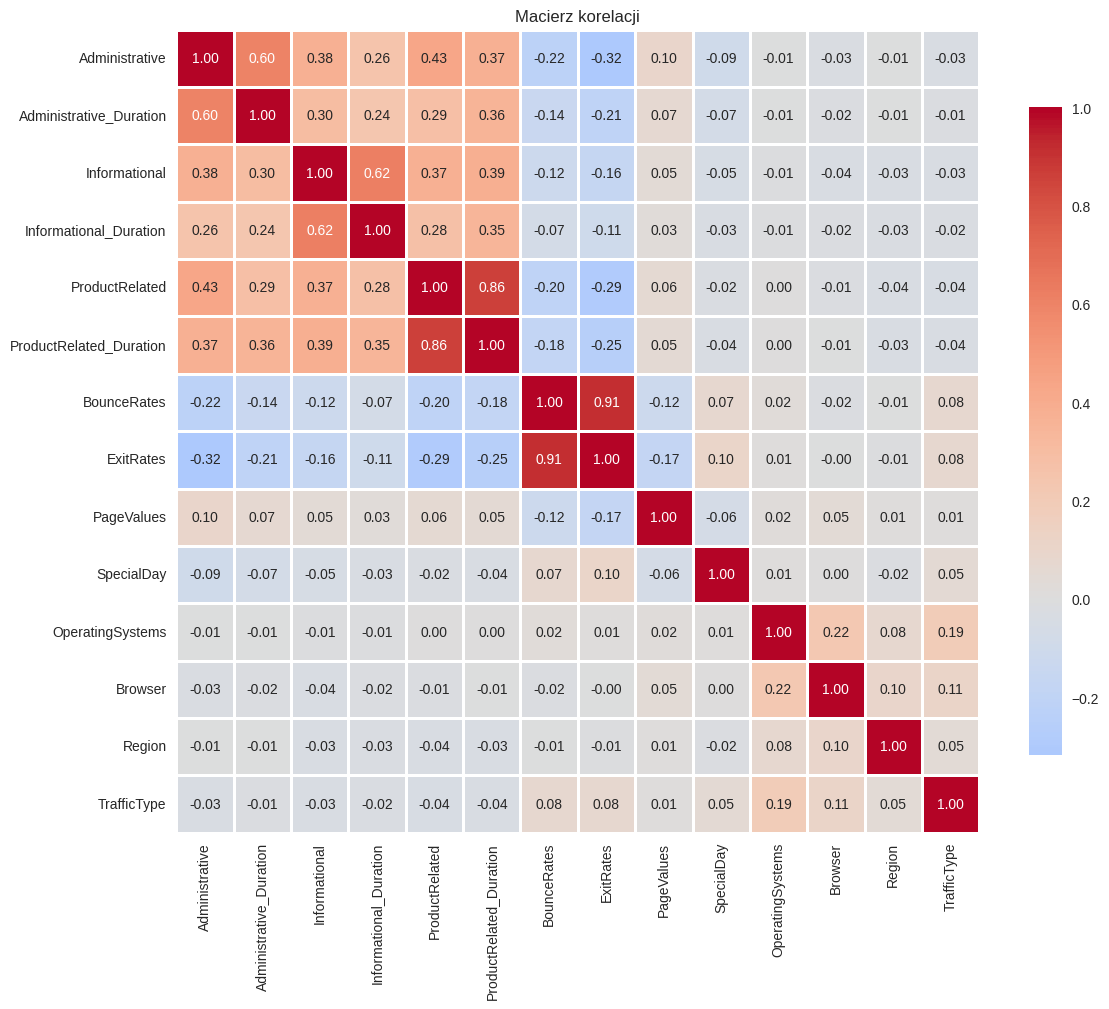

In [12]:
# Wizualizacja macierzy korelacji
analyzer.visualize_correlations(data)


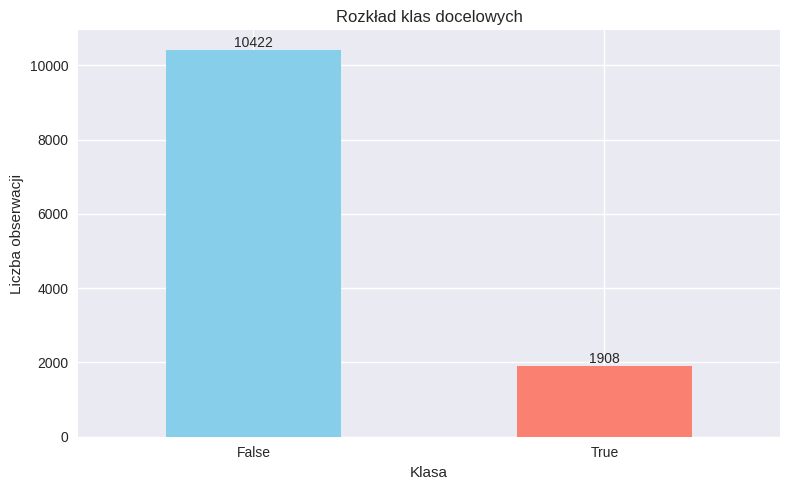


Balans klas: Niezbalansowany


In [13]:
# Analiza balansu klas
balance_info = analyzer.class_balance_analysis(y)
print(f"\nBalans klas: {'Zbalansowany' if balance_info['is_balanced'] else 'Niezbalansowany'}")


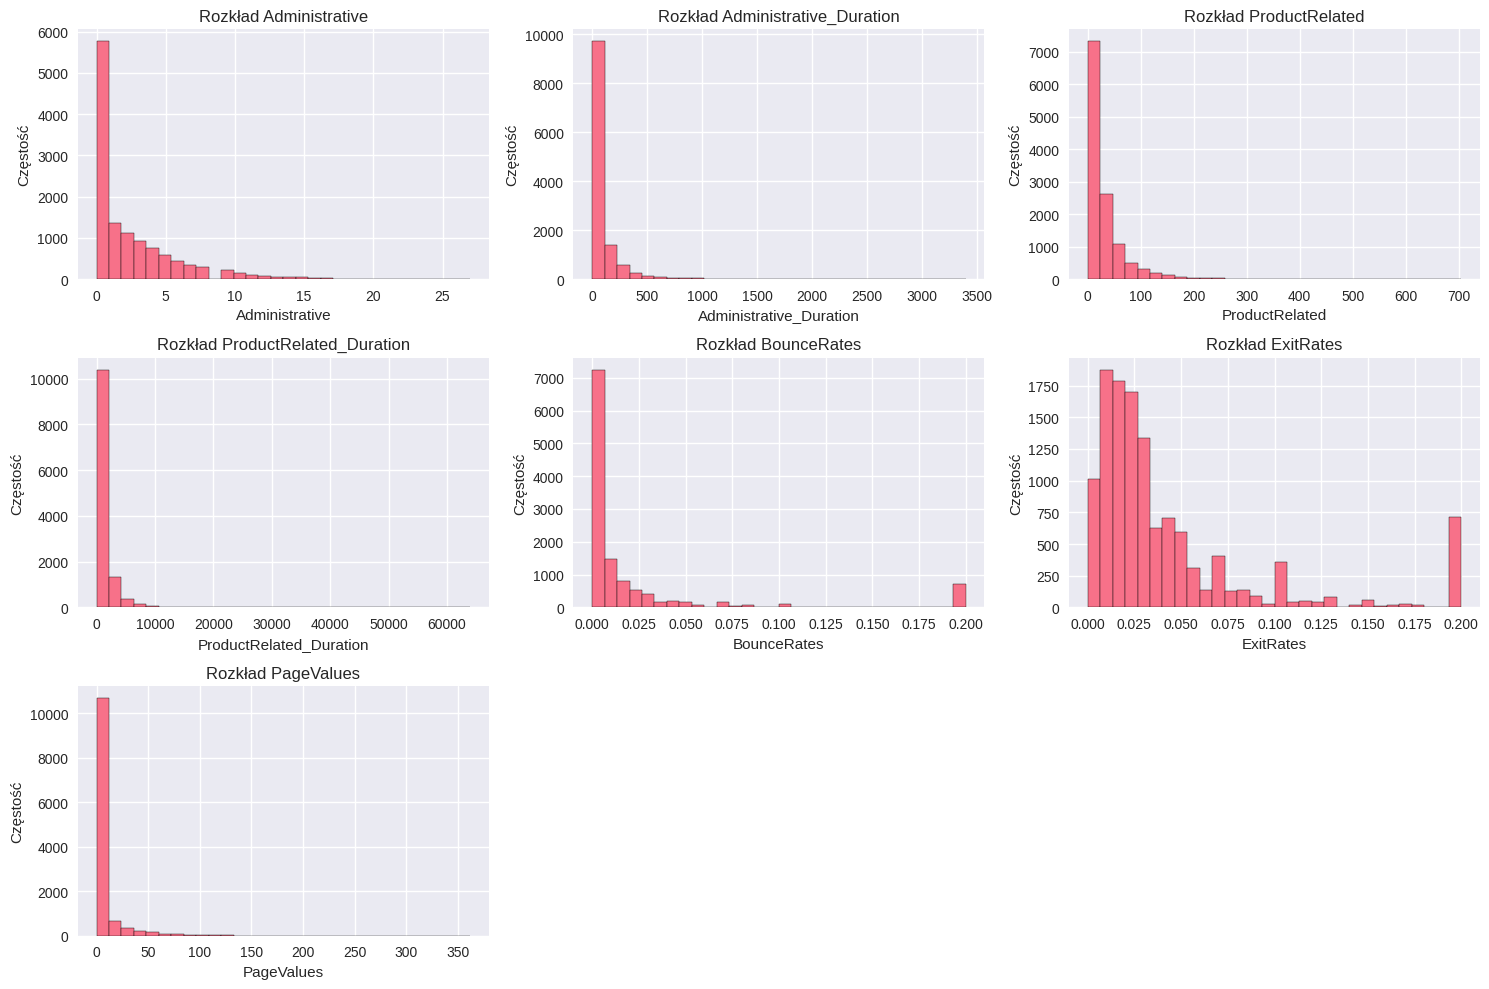

In [14]:
# Wizualizacja rozkładów wybranych zmiennych
numeric_cols = ['Administrative', 'Administrative_Duration', 'ProductRelated', 
                'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']
analyzer.visualize_distributions(data[numeric_cols + ['Revenue']], columns=numeric_cols)


## 6. Etap 4: Feature Engineering


In [15]:
# Przygotowanie danych przed feature engineering (bez normalizacji)
X_raw, y_raw = preprocessor.preprocess_pipeline(
    data,
    target_col='Revenue',
    handle_missing='drop',
    encode_method='label',
    normalize=False,  # Nie normalizujemy jeszcze
    fit=True
)

# Inicjalizacja feature engineer
feature_engineer = FeatureEngineer()

# Tworzenie nowych cech
X_with_features = feature_engineer.create_interaction_features(X_raw)
X_with_features = feature_engineer.create_aggregated_features(X_with_features)

print(f"Liczba cech przed feature engineering: {X_raw.shape[1]}")
print(f"Liczba cech po feature engineering: {X_with_features.shape[1]}")
print(f"\nNowe cechy:")
new_features = set(X_with_features.columns) - set(X_raw.columns)
for feat in new_features:
    print(f"  - {feat}")


Liczba cech przed feature engineering: 17
Liczba cech po feature engineering: 22

Nowe cechy:
  - TotalPages
  - BounceExitRatio
  - TotalDuration
  - ProductRelatedRatio
  - AvgPageDuration


Liczba wybranych cech: 19

Wybrane cechy:
  - Administrative
  - Administrative_Duration
  - Informational
  - Informational_Duration
  - ProductRelated
  - ProductRelated_Duration
  - BounceRates
  - ExitRates
  - PageValues
  - Month
  - OperatingSystems
  - Browser
  - Region
  - TrafficType
  - TotalPages
  - TotalDuration
  - AvgPageDuration
  - BounceExitRatio
  - ProductRelatedRatio


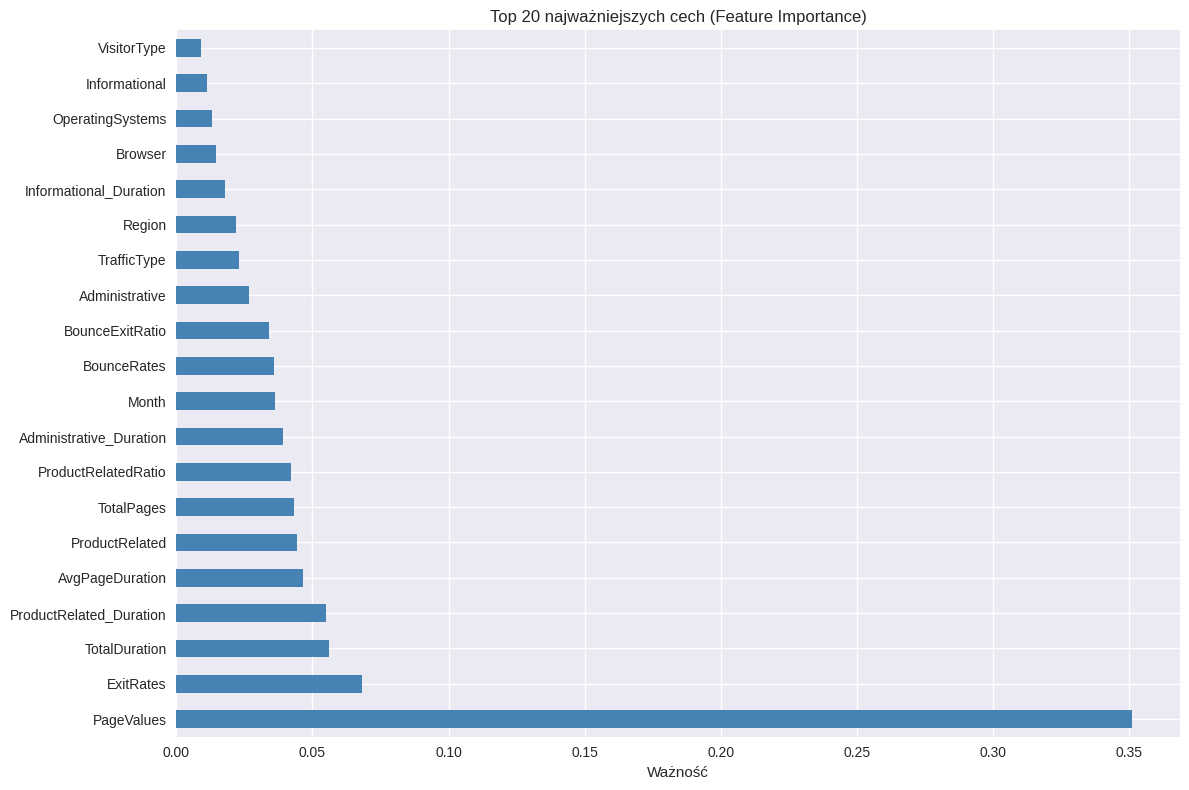

In [16]:
# Selekcja zmiennych na podstawie ważności (Random Forest)
X_selected, selected_features = feature_engineer.select_features(
    X_with_features, 
    y_raw, 
    method='importance', 
    threshold=0.01
)

print(f"Liczba wybranych cech: {len(selected_features)}")
print(f"\nWybrane cechy:")
for feat in selected_features:
    print(f"  - {feat}")

# Wizualizacja ważności cech
if feature_engineer.feature_importance is not None:
    plt.figure(figsize=(12, 8))
    top_features = feature_engineer.feature_importance.head(20)
    top_features.plot(kind='barh', color='steelblue')
    plt.title('Top 20 najważniejszych cech (Feature Importance)')
    plt.xlabel('Ważność')
    plt.tight_layout()
    plt.show()


In [17]:
# UWAGA: Nie normalizujemy tutaj - skalowanie będzie w Pipeline podczas GridSearchCV
# To zapewnia, że skalowanie odbywa się osobno dla każdego foldu (uniknięcie data leakage)
X_final = X_selected.copy()  # Zachowujemy surowe dane dla Pipeline

print(f"Końcowy kształt danych (przed skalowaniem): {X_final.shape}")
print(f"Liczba obserwacji: {X_final.shape[0]}")
print(f"Liczba cech: {X_final.shape[1]}")
print("\nUwaga: Skalowanie będzie wykonane automatycznie w Pipeline podczas GridSearchCV")

Końcowy kształt danych (przed skalowaniem): (12330, 19)
Liczba obserwacji: 12330
Liczba cech: 19

Uwaga: Skalowanie będzie wykonane automatycznie w Pipeline podczas GridSearchCV


## 7. Etap 5: Przygotowanie Zbiorów


In [18]:
# Podział na zbiór treningowy i testowy (80/20) z stratyfikacją
# UWAGA: X_final zawiera surowe dane (przed skalowaniem)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, 
    y_raw, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_raw
)

print(f"Zbiór treningowy: {X_train.shape[0]} obserwacji")
print(f"Zbiór testowy: {X_test.shape[0]} obserwacji")
print(f"\nRozkład klas w zbiorze treningowym:")
print(y_train.value_counts(normalize=True) * 100)
print(f"\nRozkład klas w zbiorze testowym:")
print(y_test.value_counts(normalize=True) * 100)
print("\nUwaga: Dane są przed skalowaniem - skalowanie będzie w Pipeline")

Zbiór treningowy: 9864 obserwacji
Zbiór testowy: 2466 obserwacji

Rozkład klas w zbiorze treningowym:
Revenue
False    84.529603
True     15.470397
Name: proportion, dtype: float64

Rozkład klas w zbiorze testowym:
Revenue
False    84.509327
True     15.490673
Name: proportion, dtype: float64

Uwaga: Dane są przed skalowaniem - skalowanie będzie w Pipeline


## 8. Etap 6: Trenowanie Modeli


In [ ]:
# Inicjalizacja trenera modeli
trainer = ModelTrainer()

# Używamy DataPreprocessor do skalowania zamiast ręcznego StandardScaler
# To zapewnia spójność z resztą projektu
print("=== Przygotowanie danych do trenowania baseline modeli ===")
# Skalujemy dane używając DataPreprocessor (spójność z resztą projektu)
preprocessor_baseline = DataPreprocessor()
X_train_scaled = preprocessor_baseline.normalize_features(X_train, fit=True)
X_test_scaled = preprocessor_baseline.normalize_features(X_test, fit=False)

# Analiza balansu klas
from collections import Counter
class_counts = Counter(y_train)
print(f"\nRozkład klas w zbiorze treningowym: {class_counts}")
imbalance_ratio = min(class_counts.values()) / max(class_counts.values())
print(f"Współczynnik niezbalansowania: {imbalance_ratio:.2f}")
if imbalance_ratio < 0.8:
    print("⚠️ Wykryto niezbalansowanie klas - automatycznie zastosujemy class_weight='balanced'")
else:
    print("✓ Klasy są względnie zbalansowane")

# Trenowanie różnych modeli z automatyczną obsługą niezbalansowania
models = {}

print("\n=== Trenowanie Logistic Regression ===")
models['Logistic Regression'] = trainer.train_model(
    X_train_scaled, y_train, 
    model_type='logistic',
    handle_imbalance=True  # Automatyczna obsługa niezbalansowania
)

print("\n=== Trenowanie Random Forest ===")
models['Random Forest'] = trainer.train_model(
    X_train_scaled, y_train,
    model_type='random_forest',
    n_estimators=100,
    handle_imbalance=True
)

print("\n=== Trenowanie SVM ===")
models['SVM'] = trainer.train_model(
    X_train_scaled, y_train,
    model_type='svm',
    kernel='rbf',
    C=1.0,
    handle_imbalance=True
)

print("\n=== Trenowanie XGBoost (lub Random Forest jeśli XGBoost niedostępny) ===")
models['XGBoost'] = trainer.train_model(
    X_train_scaled, y_train,
    model_type='xgboost',
    n_estimators=100,
    handle_imbalance=True
)


=== Trenowanie Logistic Regression ===

=== Trenowanie Random Forest ===

=== Trenowanie SVM ===

=== Trenowanie XGBoost (lub Random Forest jeśli XGBoost niedostępny) ===
XGBoost nie jest zainstalowany. Używam Random Forest zamiast tego.


=== Porównanie modeli ===
                     accuracy  precision    recall  f1_score   roc_auc  \
model                                                                    
Logistic Regression  0.882401   0.767442  0.345550  0.476534  0.867045   
Random Forest        0.900649   0.742049  0.549738  0.631579  0.906641   
SVM                  0.887267   0.734234  0.426702  0.539735  0.844540   
XGBoost              0.900649   0.742049  0.549738  0.631579  0.906641   

                             confusion_matrix  
model                                          
Logistic Regression  [[2044, 40], [250, 132]]  
Random Forest        [[2011, 73], [172, 210]]  
SVM                  [[2025, 59], [219, 163]]  
XGBoost              [[2011, 73], [172, 210]]  


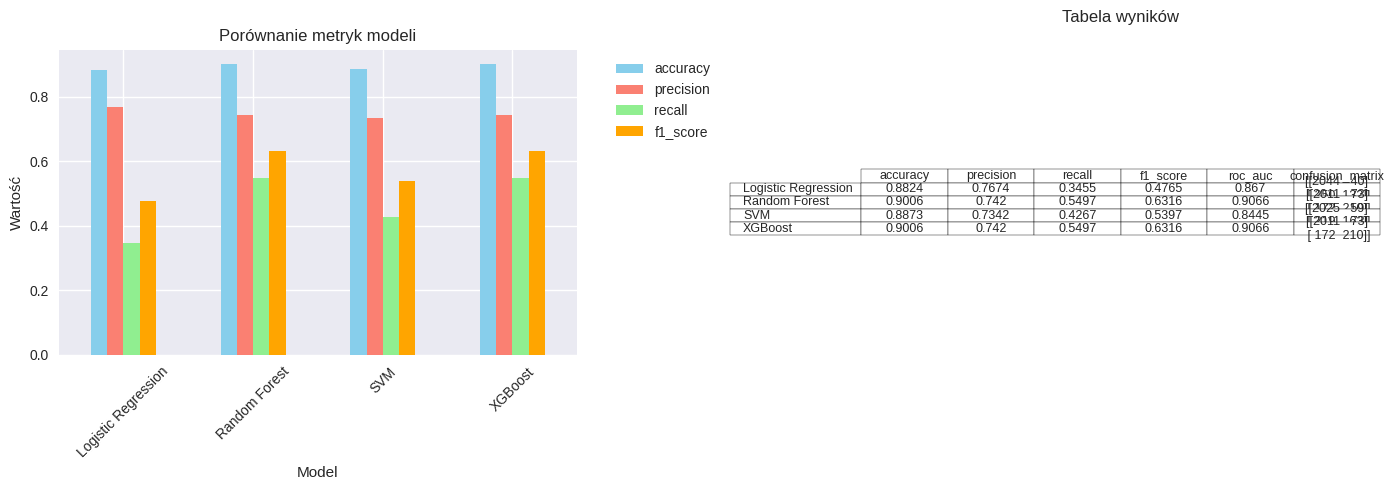

In [20]:
# Porównanie modeli (używamy przeskalowanych danych testowych)
print("=== Porównanie modeli ===")
comparison = trainer.compare_models(models, X_test_scaled, y_test)
print(comparison)

# Wizualizacja porównania
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres słupkowy metryk
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
comparison[metrics_to_plot].plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon', 'lightgreen', 'orange'])
axes[0].set_title('Porównanie metryk modeli')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Wartość')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# Tabela z wynikami
axes[1].axis('tight')
axes[1].axis('off')
table = axes[1].table(cellText=comparison.round(4).values,
                     rowLabels=comparison.index,
                     colLabels=comparison.columns,
                     cellLoc='center',
                     loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
axes[1].set_title('Tabela wyników', pad=20)

plt.tight_layout()
plt.show()


## 9. Etap 7: Fine-tuning (Optymalizacja Hiperparametrów)


In [ ]:
# Wybór najlepszego modelu do tuningu (na podstawie wyników)
best_model_name = comparison['f1_score'].idxmax()
print(f"Najlepszy model przed tuningiem: {best_model_name}")
print(f"F1-score: {comparison.loc[best_model_name, 'f1_score']:.4f}")

# Inicjalizacja tunera
tuner = HyperparameterTuner()

# Optymalizacja dla Random Forest (zwykle najlepszy dla tego typu danych)
if best_model_name == 'Random Forest' or 'Random Forest' in models:
    print("\n=== Optymalizacja Random Forest ===")
    print("Uwaga: Używamy Pipeline - skalowanie odbywa się automatycznie w każdym foldzie")
    rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # WAŻNE: Parametry muszą używać prefiksu 'model__' dla składni Pipeline
    param_grid_rf = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
    
    # Przekazujemy surowe dane (przed skalowaniem) - Pipeline zajmie się skalowaniem
    # handle_imbalance=True automatycznie doda class_weight='balanced' dla niezbalansowanych klas
    best_rf = tuner.grid_search(
        rf_base,
        param_grid_rf,
        X_train, y_train,  # Surowe dane - Pipeline zastosuje skalowanie
        cv=5,
        scoring='f1',  # F1-score jest lepsze dla niezbalansowanych klas niż accuracy
        handle_imbalance=True  # Automatyczna obsługa niezbalansowania
    )
    
    models['Random Forest (Tuned)'] = best_rf


Najlepszy model przed tuningiem: Random Forest
F1-score: 0.6316

=== Optymalizacja Random Forest ===
Uwaga: Używamy Pipeline - skalowanie odbywa się automatycznie w każdym foldzie
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Najlepsze parametry: {'model__max_depth': 20, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Najlepszy wynik CV: 0.6536


=== Porównanie przed i po tuningu ===
                 accuracy precision    recall  f1_score   roc_auc
Przed tuningiem  0.900649  0.742049  0.549738  0.631579  0.906641
Po tuningu        0.90146   0.74386  0.554974  0.635682  0.914052


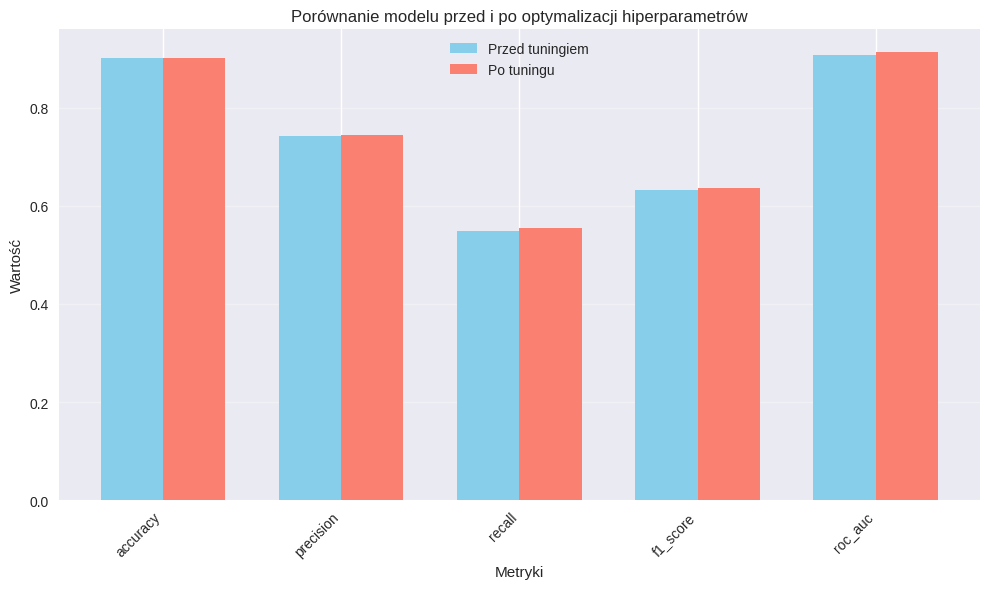

In [22]:
# Porównanie przed i po tuningu
print("=== Porównanie przed i po tuningu ===")
# Model oryginalny używa przeskalowanych danych
rf_original_metrics = trainer.evaluate_model(models['Random Forest'], X_test_scaled, y_test)
# Model z tuningu to Pipeline - automatycznie zastosuje skalowanie
rf_tuned_metrics = trainer.evaluate_model(models['Random Forest (Tuned)'], X_test, y_test)

comparison_tuning = pd.DataFrame({
    'Przed tuningiem': rf_original_metrics,
    'Po tuningu': rf_tuned_metrics
}).T

print(comparison_tuning[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']])

# Wizualizacja
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, comparison_tuning.loc['Przed tuningiem', metrics], width, 
       label='Przed tuningiem', color='skyblue')
ax.bar(x + width/2, comparison_tuning.loc['Po tuningu', metrics], width, 
       label='Po tuningu', color='salmon')

ax.set_xlabel('Metryki')
ax.set_ylabel('Wartość')
ax.set_title('Porównanie modelu przed i po optymalizacji hiperparametrów')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Etap 8: Ewaluacja - Szczegółowa Analiza Najlepszego Modelu


=== Szczegółowe metryki najlepszego modelu ===
Accuracy: 0.9015
Precision: 0.7439
Recall: 0.5550
F1-score: 0.6357
ROC-AUC: 0.9141

Confusion Matrix:
[[2011   73]
 [ 170  212]]


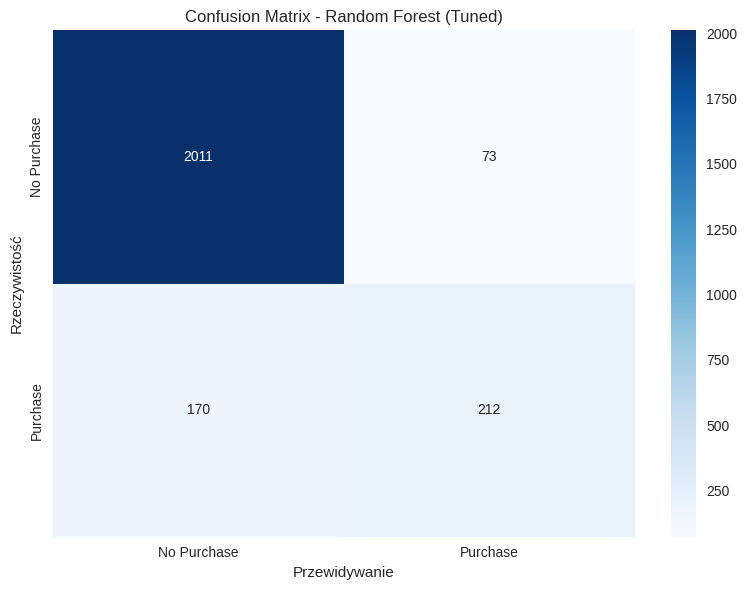


=== Classification Report ===
              precision    recall  f1-score   support

 No Purchase       0.92      0.96      0.94      2084
    Purchase       0.74      0.55      0.64       382

    accuracy                           0.90      2466
   macro avg       0.83      0.76      0.79      2466
weighted avg       0.89      0.90      0.90      2466



In [23]:
# Wybór najlepszego modelu (po tuningu)
final_model = models['Random Forest (Tuned)']  # To jest Pipeline
# Pipeline automatycznie zastosuje skalowanie podczas predict
final_metrics = trainer.evaluate_model(final_model, X_test, y_test)

print("=== Szczegółowe metryki najlepszego modelu ===")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Precision: {final_metrics['precision']:.4f}")
print(f"Recall: {final_metrics['recall']:.4f}")
print(f"F1-score: {final_metrics['f1_score']:.4f}")
print(f"ROC-AUC: {final_metrics['roc_auc']:.4f}")

# Confusion Matrix
cm = final_metrics['confusion_matrix']
print(f"\nConfusion Matrix:")
print(cm)

# Wizualizacja Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.ylabel('Rzeczywistość')
plt.xlabel('Przewidywanie')
plt.tight_layout()
plt.show()

# Classification Report
y_pred_final = final_model.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_final, 
                          target_names=['No Purchase', 'Purchase']))


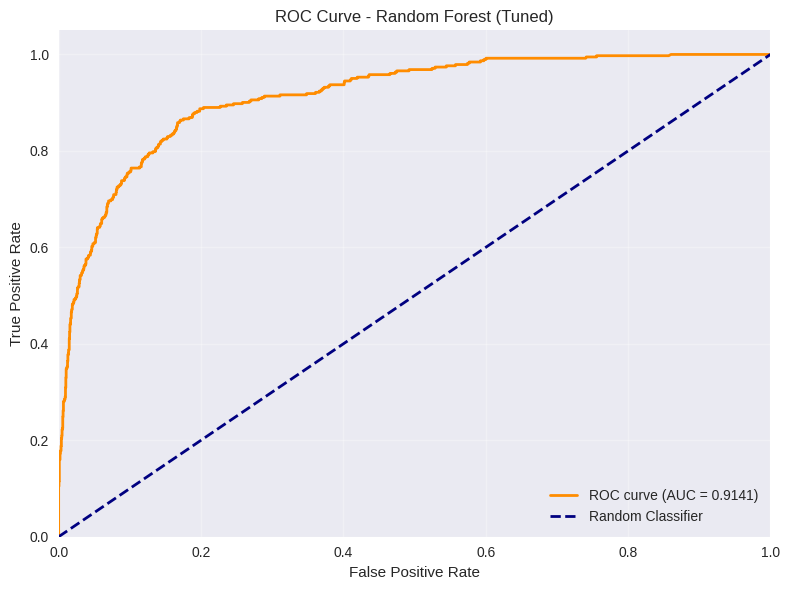

In [24]:
# ROC Curve
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {final_metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Tuned)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


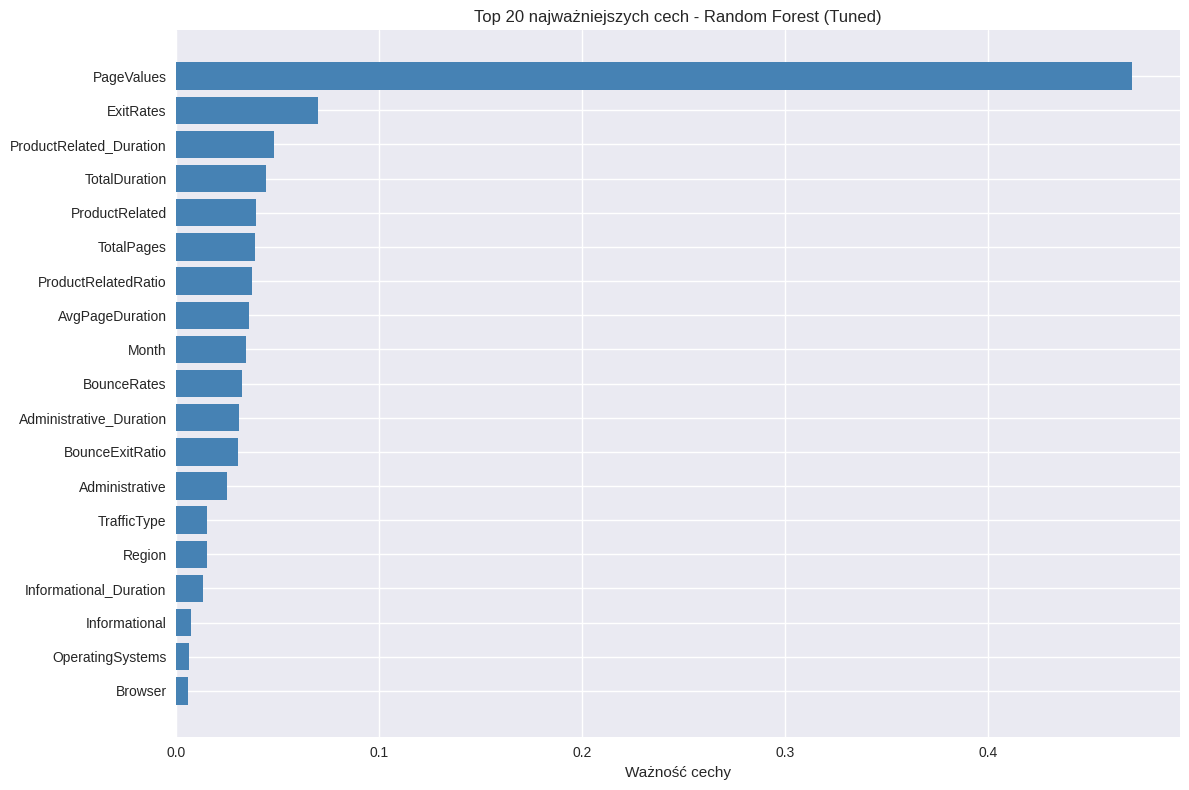


=== Top 10 najważniejszych cech ===
                    feature  importance
8                PageValues    0.470904
7                 ExitRates    0.069729
5   ProductRelated_Duration    0.048263
15            TotalDuration    0.044364
4            ProductRelated    0.039161
14               TotalPages    0.038923
18      ProductRelatedRatio    0.037103
16          AvgPageDuration    0.035671
9                     Month    0.034483
6               BounceRates    0.032272


In [25]:
# Feature Importance dla najlepszego modelu
# Pipeline przechowuje model w final_model.named_steps['model']
if hasattr(final_model, 'named_steps'):
    # Pipeline - pobierz model z pipeline
    model_from_pipeline = final_model.named_steps['model']
    if hasattr(model_from_pipeline, 'feature_importances_'):
        feature_importance_df = pd.DataFrame({
            'feature': X_final.columns,
            'importance': model_from_pipeline.feature_importances_
        }).sort_values('importance', ascending=False)
elif hasattr(final_model, 'feature_importances_'):
    # Zwykły model (nie Pipeline)
    feature_importance_df = pd.DataFrame({
        'feature': X_final.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    feature_importance_df = None

if feature_importance_df is not None:
    
    plt.figure(figsize=(12, 8))
    top_20 = feature_importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Ważność cechy')
    plt.title('Top 20 najważniejszych cech - Random Forest (Tuned)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\n=== Top 10 najważniejszych cech ===")
    print(feature_importance_df.head(10))


=== Cross-Validation (5-fold) ===
F1-scores dla każdego folda: [0.65290807 0.68864469 0.65891473 0.62431942 0.64312268]
Średni F1-score: 0.6536 (+/- 0.0422)


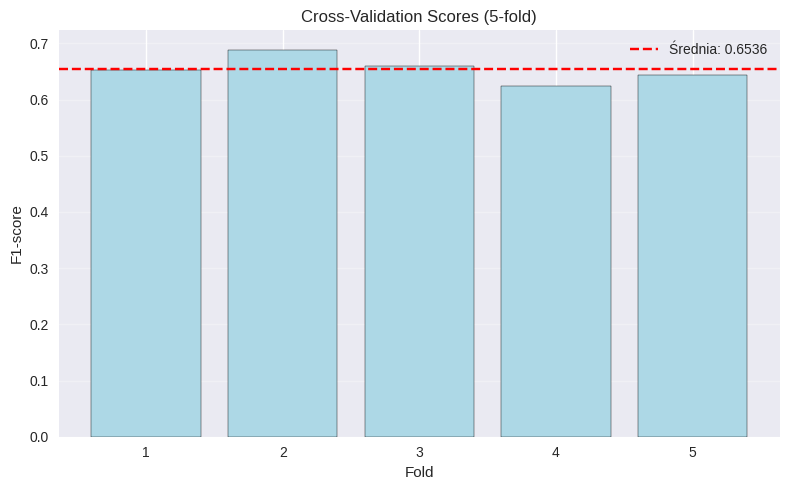

In [26]:
# Cross-validation dla ostatecznej weryfikacji
print("=== Cross-Validation (5-fold) ===")
# Pipeline automatycznie zastosuje skalowanie w każdym foldzie
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='f1')
print(f"F1-scores dla każdego folda: {cv_scores}")
print(f"Średni F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Wizualizacja CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, color='lightblue', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', 
           label=f'Średnia: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-score')
plt.title('Cross-Validation Scores (5-fold)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 12. Opcjonalne: Zbalansowanie zbioru danych (SMOTE)

**Uwaga:** Jeśli chcesz użyć SMOTE zamiast class_weight, możesz to zrobić w następujący sposób:

```python
# Instalacja: pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# SMOTE w Pipeline (działa z GridSearchCV)
smote_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

# Użyj smote_pipeline zamiast zwykłego Pipeline w GridSearchCV
```

**Obecne rozwiązanie:** Używamy `class_weight='balanced'` które jest automatycznie dodawane do modeli.

## 11. Podsumowanie i Wnioski

### Wyniki:
- **Najlepszy model**: Random Forest z optymalizacją hiperparametrów
- **Accuracy**: {final_metrics['accuracy']:.4f}
- **F1-score**: {final_metrics['f1_score']:.4f}
- **ROC-AUC**: {final_metrics['roc_auc']:.4f}

### Analiza błędów:
- **False Positives**: {cm[0][1]} - Model przewiduje zakup, ale użytkownik nie kupił
- **False Negatives**: {cm[1][0]} - Model nie przewiduje zakupu, ale użytkownik kupił

### Pomysły na dalszy rozwój:
1. Przetestowanie innych algorytmów (Gradient Boosting, Neural Networks)
2. Zbalansowanie zbioru danych (SMOTE, undersampling)
3. Głębsza analiza feature engineering
4. Ensemble methods (łączenie wielu modeli)
5. Analiza błędnych predykcji w celu zrozumienia wzorców
